In [1]:
import os
import streamlit as st
from typing import TypedDict, List
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from newspaper import Article
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
class ResearchState(TypedDict):
    """
    Represents the state of our research agent.

    Attributes:
        topic (str): The research topic provided by the user.
        urls (List[str]): A list of URLs found for the topic.
        articles (List[dict]): A list of dictionaries, each containing a URL and its scraped content.
        summary (str): The final, summarized report in bullet points.
    """
    topic: str
    urls: List[str]
    articles: List[dict]
    summary: str

try:
    search_tool = TavilySearchResults(max_results=4)
    llm = ChatGroq(model="llama3-8b-8192", temperature=0)
except Exception as e:
    st.error(f"Failed to initialize tools. Please check your API keys. Error: {e}")
    st.stop()

C:\Users\Soham\AppData\Local\Temp\ipykernel_8632\1230000310.py:17: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=4)


In [3]:
def search_node(state: ResearchState):
    """
    Searches for relevant articles for the given topic.

    Args:
        state (ResearchState): The current state of the research agent.

    Returns:
        dict: A dictionary containing the list of found URLs.
    """
    print("🔍 Searching for relevant articles...")
    results = search_tool.invoke(state['topic'])
    urls = [res['url'] for res in results]
    return {"urls": urls}

In [4]:
def scrape_node(state: ResearchState):
    """
    Scrapes the content from the found URLs.

    Args:
        state (ResearchState): The current state of the research agent.

    Returns:
        dict: A dictionary containing the list of scraped articles.
    """
    print("📰 Scraping article content...")
    scraped_articles = []
    for i, url in enumerate(state['urls']):
        try:
            article = Article(url)
            article.download()
            article.parse()
            scraped_articles.append({"url": url, "content": article.text[:4000]}) # Truncate for context window
        except Exception as e:
            print(f"⚠️ Could not scrape {url}: {e}")
    return {"articles": scraped_articles}

In [5]:
def summarize_node(state: ResearchState):
    """
    Generates a combined summary from all scraped articles.

    Args:
        state (ResearchState): The current state of the research agent.

    Returns:
        dict: A dictionary containing the final bullet-point summary.
    """
    print("✍️ Generating summary...")
    
    # Create a unified text from all articles for the LLM
    text_content = ""
    for article in state['articles']:
        text_content += f"--- Article from {article['url']} ---\n\n{article['content']}\n\n"

    # Define the prompt for the LLM
    prompt = f"""
    You are an expert research assistant.
    Your task is to create a concise, easy-to-read summary in bullet points based on the provided articles for the topic: "{state['topic']}".

    Instructions:
    1.  Synthesize information from all the articles into a single, cohesive summary.
    2.  Do NOT list summaries for each article separately.
    3.  The summary must be in bullet points.
    4.  The tone should be informative and objective.

    Here is the content from the articles:
    {text_content}
    """
    
    # Invoke the LLM to get the summary
    summary_result = llm.invoke(prompt)
    return {"summary": summary_result.content}

In [6]:
builder = StateGraph(ResearchState)

# Add the nodes to the graph
builder.add_node("search", search_node)
builder.add_node("scrape", scrape_node)
builder.add_node("summarize", summarize_node)

# Define the edges that connect the nodes
builder.add_edge(START, "search")
builder.add_edge("search", "scrape")
builder.add_edge("scrape", "summarize")
builder.add_edge("summarize", END)

# Compile the graph into a runnable object
graph = builder.compile()

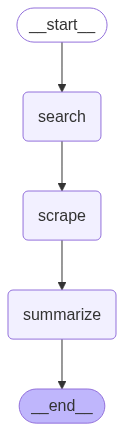

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))